In [1]:
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import pandas as pd
from aldiscore.prediction import utils
from aldiscore import ROOT, RSTATE
from aldiscore.constants.constants import STAT_SEP

In [2]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
feat_df, drop_df, labels = utils.load_features(
    data_dir,
    exclude_features=["is_dna", "num_seqs", "seq_length"],
)

print(feat_df.shape)
print(drop_df.shape)
print(labels.shape)

Dropping 0 NaN rows...
(11431, 361)
(11431, 21)
(11431,)


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

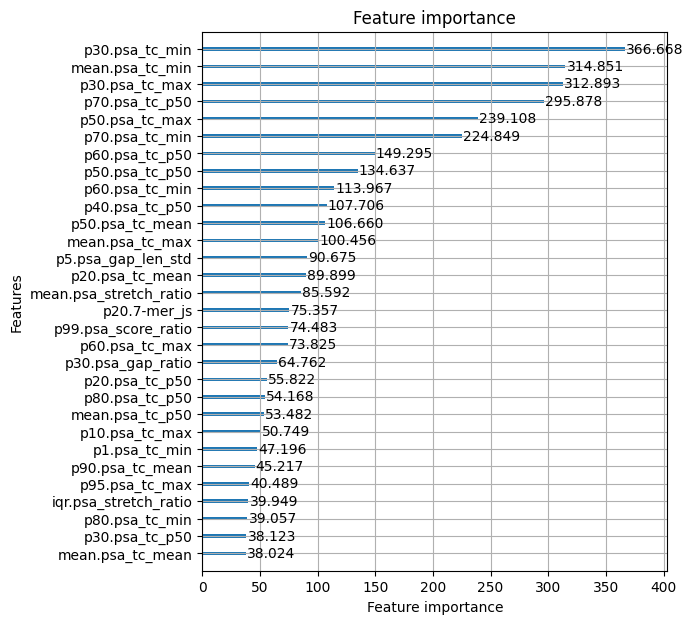

In [3]:
from aldiscore.prediction.predictor import DifficultyPredictor
import lightgbm as lgb

model = DifficultyPredictor("latest").model

feat_df = feat_df[model.feature_name()]
imps = model.feature_importance("gain")
lgb.plot_importance(model, figsize=(6, 7), importance_type="gain", max_num_features=30)

In [4]:
col_mapping = {
    "n_estimators": "num_iterations",
    "colsample_bytree": "feature_fraction",
    "colsample_bynode": "feature_fraction_bynode",
    "learning_rate": "learning_rate",
    "min_data": "min_data_in_leaf",
    "num_leaves": "num_leaves",
    "lambda_l1": "lambda_l1",
    "lambda_l2": "lambda_l2",
    "subsample": "bagging_fraction",
}
param_df = pd.DataFrame(model.params)[col_mapping.values()]
param_df.columns = col_mapping.keys()
print(param_df.to_latex(escape=True))

\begin{tabular}{lrrrrrrrrr}
\toprule
 & n\_estimators & colsample\_bytree & colsample\_bynode & learning\_rate & min\_data & num\_leaves & lambda\_l1 & lambda\_l2 & subsample \\
\midrule
0 & 1200 & 0.088135 & 0.217743 & 0.037031 & 22 & 43 & 0.000043 & 0.000207 & 0.402253 \\
\bottomrule
\end{tabular}



In [5]:
imp_df = pd.concat([pd.Series(model.feature_name()), pd.Series(imps)], axis=1)
imp_df.columns = ["name", "gain"]
imp_df
imp_df["group"] = pd.Series(imp_df.name.str.split(".").map(lambda v: v[-1]))
imp_df.sort_values("gain", ascending=False)
print(set(imp_df.group))
for pat in [
    "mean",
    "min",
    "max",
    "mean",
    "iqr",
    "p50",
    "std",
]:
    imp_df.group = imp_df.group.str.rsplit("_" + pat).map(lambda v: v[0])
groups = set(imp_df.group)
groups

{'psa_gap_len_mean', 'psa_tc_std', 'char_ent', 'psa_gap_len_std', '7-mer_ent', 'psa_score_ratio', '4-mer_js', 'lbgp', '13-mer_ent', 'psa_gap_ratio', 'psa_tc_min', 'hpoly_js_len', 'psa_tc_mean', '10-mer_ent', 'psa_stretch_ratio', '7-mer_js', 'psa_tc_max', '4-mer_ent', 'char_js', 'psa_tc_p50', 'hpoly_js_count'}


{'10-mer_ent',
 '13-mer_ent',
 '4-mer_ent',
 '4-mer_js',
 '7-mer_ent',
 '7-mer_js',
 'char_ent',
 'char_js',
 'hpoly_js_count',
 'hpoly_js_len',
 'lbgp',
 'psa_gap_len',
 'psa_gap_ratio',
 'psa_score_ratio',
 'psa_stretch_ratio',
 'psa_tc'}

In [6]:
# imp_df.loc[imp_df.name.str.contains("gap_len")].sort_values(
#     "gain", ascending=False
# ).iloc[:20]
rel = imp_df["gain"] / imp_df["gain"].sum()
print(rel.min(), rel.max())
imp_df.loc[rel > 0.001].sort_values("gain", ascending=False)

7.57638067388547e-05 0.06867524415001817


,name,gain,group
81,p30.psa_tc_min,366.668234,psa_tc
75,mean.psa_tc_min,314.850523,psa_tc
135,p30.psa_tc_max,312.893253,psa_tc
157,p70.psa_tc_p50,295.877600,psa_tc
137,p50.psa_tc_max,239.107652,psa_tc
...,...,...,...
225,p30.psa_gap_len_mean,5.741842,psa_gap_len
7,p10.char_ent,5.689534,char_ent
126,iqr.psa_tc_std,5.489799,psa_tc
9,p30.char_ent,5.483022,char_ent


In [8]:
stat_df = imp_df.drop("name", axis=1).groupby("group").aggregate(["sum", "count"])
T_GAIN = "Gain (%)"
# M_GAIN = "mean_gain (%)"
stat_df.columns = [T_GAIN, "Count"]
stat_df = stat_df.sort_values(T_GAIN, ascending=False)
gain_cols = [T_GAIN]
stat_df[gain_cols] = (stat_df[gain_cols] / stat_df[gain_cols].sum(axis=0)).round(
    4
) * 100
stat_df

,Gain (%),Count
Feature Group,,
psa_tc,68.63,90
psa_gap_len,5.47,36
psa_gap_ratio,5.45,18
psa_score_ratio,4.91,18
psa_stretch_ratio,3.32,18
7-mer_js,2.43,18
10-mer_ent,1.61,18
char_js,1.56,18
13-mer_ent,1.50,18


In [11]:
stat_df["Description"] = ""

stat_df.at["psa_tc", "Description"] = "Transitive consistency of PSA triplets."
stat_df.at["psa_score_ratio", "Description"] = (
    "Alignment score scaled by the minimum sequence length."
)
stat_df.at["psa_gap_ratio", "Description"] = (
    "Number of gaps divided by total number of characters."
)
stat_df.at["psa_gap_len", "Description"] = (
    "Features based on the lengths of gap regions."
)
stat_df.at["char_ent", "Description"] = "Shannon entropy of character distributions."
stat_df.at["char_js", "Description"] = (
    "Pairwise Jensen-Shannon divergence of character distributions."
)
stat_df.at["psa_stretch_ratio", "Description"] = (
    "Ratio between max. sequence length and alignment length."
)
stat_df.at["hpoly_js_len", "Description"] = (
    "Pairwise Jensen-Shannon divergence of homopolymer length distributions."
)
stat_df.at["hpoly_js_count", "Description"] = (
    "Pairwise Jensen-Shannon divergence of homopolymer count distributions."
)
stat_df.at["lbgp", "Description"] = (
    "Lower bound on the gap percentage (1 - mean_len/max_len)."
)
for i in [4, 7, 10, 13]:
    if i < 10:
        stat_df.at[f"{i}-mer_js", "Description"] = (
            f"Pairwise Jensen-Shannon divergence of {i}-mer distributions."
        )
    stat_df.at[f"{i}-mer_ent", "Description"] = (
        f"Shannon entropy of {i}-mer distributions."
    )
stat_df.index.name = "Feature Group"
print(stat_df.to_latex(escape=True, float_format="%.2f"))

\begin{tabular}{lrrl}
\toprule
 & Gain (\%) & Count & Description \\
Feature Group &  &  &  \\
\midrule
psa\_tc & 68.63 & 90 & Transitive consistency of PSA triplets. \\
psa\_gap\_len & 5.47 & 36 & Features based on the lengths of gap regions. \\
psa\_gap\_ratio & 5.45 & 18 & Number of gaps divided by total number of characters. \\
psa\_score\_ratio & 4.91 & 18 & Alignment score scaled by the minimum sequence length. \\
psa\_stretch\_ratio & 3.32 & 18 & Ratio between max. sequence length and alignment length. \\
7-mer\_js & 2.43 & 18 & Pairwise Jensen-Shannon divergence of 7-mer distributions. \\
10-mer\_ent & 1.61 & 18 & Shannon entropy of 10-mer distributions. \\
char\_js & 1.56 & 18 & Pairwise Jensen-Shannon divergence of character distributions. \\
13-mer\_ent & 1.50 & 18 & Shannon entropy of 13-mer distributions. \\
char\_ent & 1.32 & 18 & Shannon entropy of character distributions. \\
4-mer\_js & 1.24 & 18 & Pairwise Jensen-Shannon divergence of 4-mer distributions. \\
7-mer\_ent

In [12]:
print(stat_df.drop("Gain (%)", axis=1).to_latex(escape=True, float_format="%.2f"))

\begin{tabular}{lrl}
\toprule
 & Count & Description \\
Feature Group &  &  \\
\midrule
psa\_tc & 90 & Transitive consistency of PSA triplets. \\
psa\_gap\_len & 36 & Features based on the lengths of gap regions. \\
psa\_gap\_ratio & 18 & Number of gaps divided by total number of characters. \\
psa\_score\_ratio & 18 & Alignment score scaled by the minimum sequence length. \\
psa\_stretch\_ratio & 18 & Ratio between max. sequence length and alignment length. \\
7-mer\_js & 18 & Pairwise Jensen-Shannon divergence of 7-mer distributions. \\
10-mer\_ent & 18 & Shannon entropy of 10-mer distributions. \\
char\_js & 18 & Pairwise Jensen-Shannon divergence of character distributions. \\
13-mer\_ent & 18 & Shannon entropy of 13-mer distributions. \\
char\_ent & 18 & Shannon entropy of character distributions. \\
4-mer\_js & 18 & Pairwise Jensen-Shannon divergence of 4-mer distributions. \\
7-mer\_ent & 18 & Shannon entropy of 7-mer distributions. \\
hpoly\_js\_count & 18 & Pairwise Jensen-Sha